In [10]:
# %matplotlib inline

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd

Helper functions:

In [11]:
def getConcatedDf(dict_of_dfs:dict[str, pd.DataFrame], name:str):
    """
    Gets all DataFrames pointed by name in dictionary
    """
    return pd.concat([v for k, v in dict_of_dfs.items()
                      if name in k], ignore_index=True)


def column_first_name_rename(df: pd.DataFrame, search: str, new_name: str):
    """
    Gets first occurrence of columns name with "search" in Pandas DataFrame and rename it to shorter "new_name".
    """
    for k in df.columns:
        if search in k:
            df.rename(columns={k: new_name}, inplace=True)
            break


def sam_readcsv(x): return pd.read_csv(x, skiprows=1, index_col=False)

Finding files in given path. In my case ./input/samsunghealth

In [12]:
samsung_base_dir = os.path.join('.', 'input', 'samsunghealth')
samsung_dump_dirs = glob(os.path.join(samsung_base_dir, '*'))
samsung_dump_dir = os.path.dirname(samsung_dump_dirs[0])
display(len(samsung_dump_dirs), 'dumps found, taking first:', samsung_dump_dir)
samsung_csv_paths = glob(os.path.join(samsung_base_dir, '*.csv'))
display(len(samsung_csv_paths), 'csvs found')
samsung_json_paths = glob(os.path.join(
    samsung_base_dir,  'jsons', '**', '*.json'), recursive=True)
display(len(samsung_json_paths), 'jsons found')

48

'dumps found, taking first:'

'.\\input\\samsunghealth'

46

'csvs found'

4627

'jsons found'

Getting all csv's to one dictionary of DataFrame's

In [ ]:
all_csv_df = {os.path.basename(j).replace(
    'com.samsung.', ''): sam_readcsv(j) for j in samsung_csv_paths}
for k, v in all_csv_df.items():
    display(k, 'readings:', v.shape[0])
    display(v.sample(2 if v.shape[0] > 2 else 1))

Get all DataFrames with ".sleep." string in key of dictionary

In [14]:
sleep_df = getConcatedDf(all_csv_df, '.sleep.')
column_first_name_rename(sleep_df, "create_time", "create_time")

Change creation date-time of record to more unified date.

In [21]:

sleep_df['create_time'] = pd.to_datetime(sleep_df['create_time'])
sleep_df['create_day'] = sleep_df['create_time'].dt.date


Data must be cleaned, because there can be more than one sleep record in day. For simplify I get just greatest score. 

In [22]:

# Sleep rank by day, removed duplicates, one maximal measurement
new_sleep_df = sleep_df.copy()
new_sleep_df = new_sleep_df.dropna(subset='mental_recovery')
idx = new_sleep_df.groupby('create_day')['mental_recovery'].idxmax()
new_sleep_df = new_sleep_df.loc[idx]


Simple plot by day.

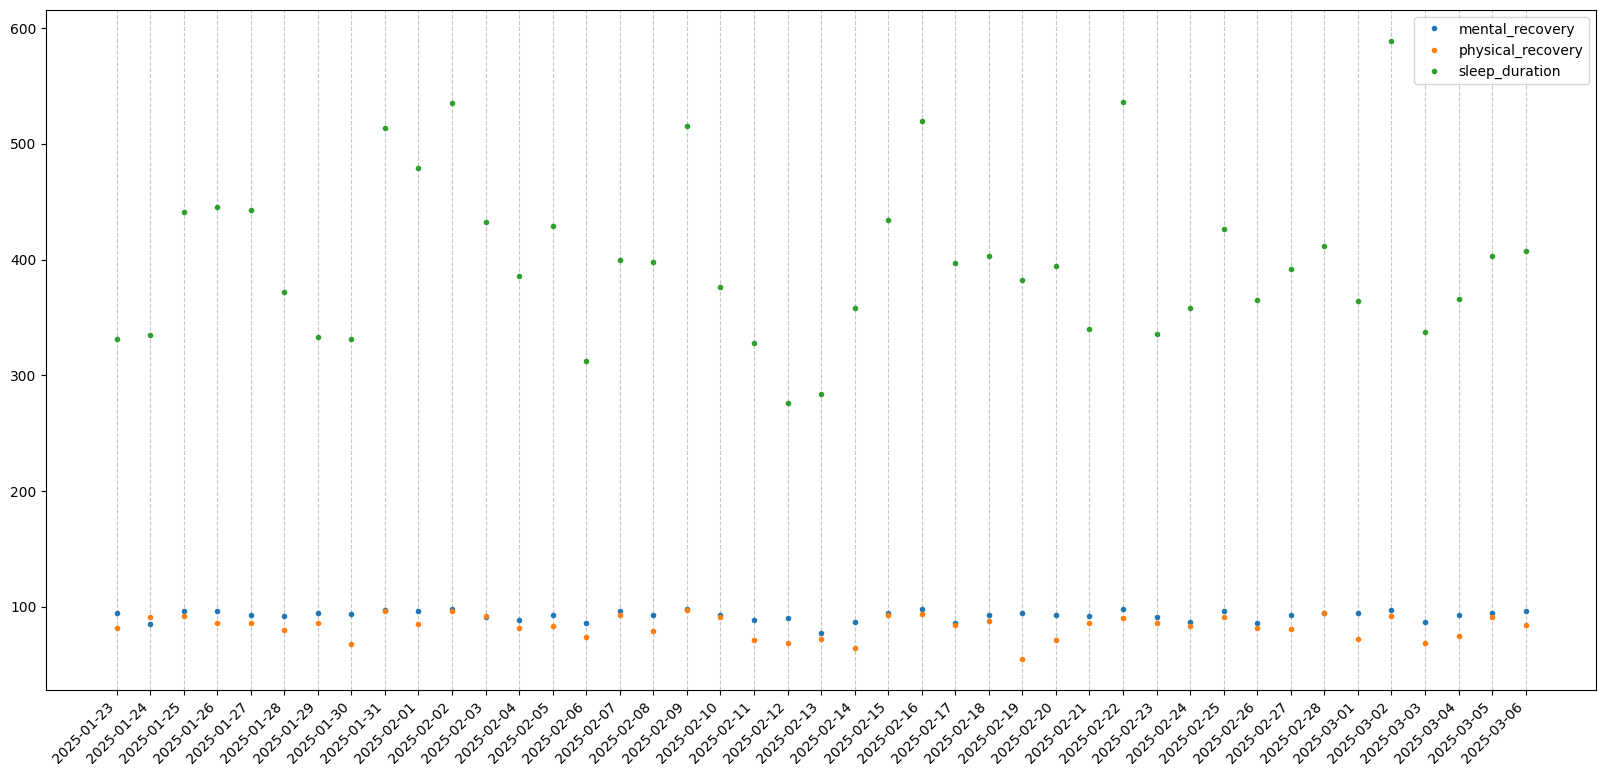

In [29]:

fig, ax1 = plt.subplots(1, 1, figsize=(20, 10), )
ax1.plot(new_sleep_df['create_day'],
         new_sleep_df['mental_recovery'], '.', label='mental_recovery')
ax1.plot(new_sleep_df['create_day'], new_sleep_df['physical_recovery'],
         '.', label='physical_recovery')
ax1.plot(new_sleep_df['create_day'],
         new_sleep_df['sleep_duration'], '.', label='sleep_duration')
ax1.set_xticks(new_sleep_df['create_day'])
ax1.grid(axis='x',linestyle="--", alpha=0.7)
ax1.legend()
fig.autofmt_xdate(rotation=45)


Pair plot to view relations.

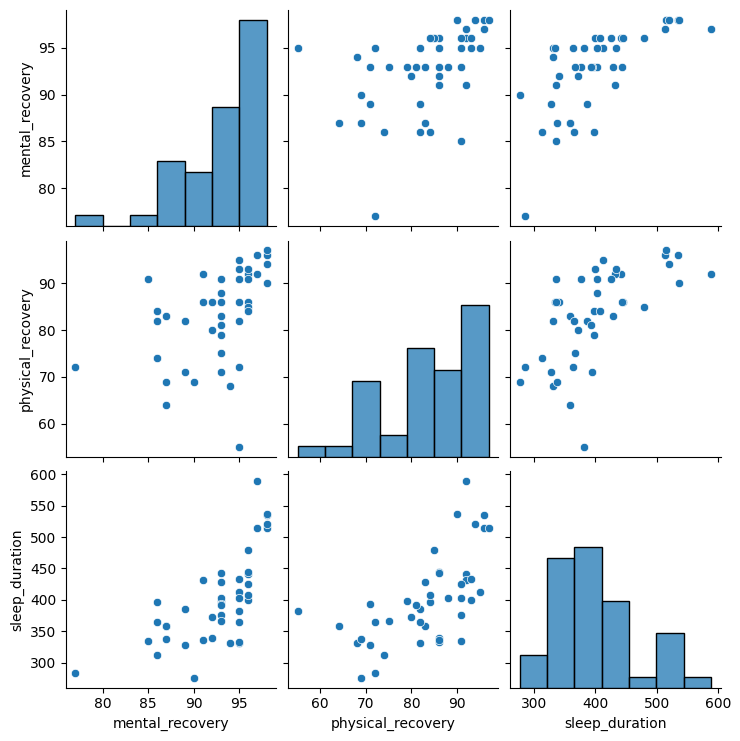

In [30]:

sns.pairplot(data=new_sleep_df[[
             'mental_recovery', 'physical_recovery', 'sleep_duration']])
